### Fix matplotlib [bug](https://discussions.udacity.com/t/attributeerror-numpy-ndarray-object-has-no-attribute-mask-after-extracting-celeba/684064/13)

In [1]:
# !sudo pip install -U matplotlib==2.2.2

In [2]:
# check for version of matplotlib without ndarray has no attribute 'mask', should be 2.2.2
!pip freeze | grep matplotlib

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
matplotlib==2.2.2


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

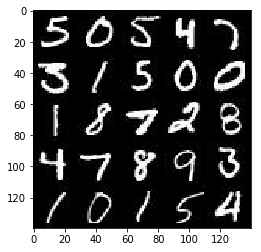

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L').convert("RGB"), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

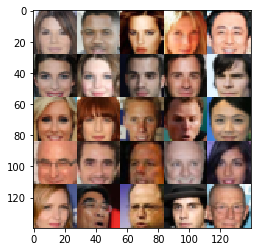

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input layer is 28 x 28 x number of channels

        # conv layer 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # output is 14 x 14 x 64
        
        # conv layer 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True) # batch norm
        relu2 = tf.maximum(alpha * bn2, bn2) # leaky relu
        # output is 7 x 7 x 128
        
        # conv layer 3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True) # batch norm
        relu3 = tf.maximum(alpha * bn3, bn3) # leaky relu
        # output is 4 x 4 x 256 (with padding same)

        # dense layer
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256)) # flatten to n x 4096
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train # don't reuse the parameters when training
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train) # batch norm
        x1 = tf.maximum(alpha * x1, x1) # leaky relu
        # output is 4 x 4 x 512
        
        # First conv layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid') # get height of 7
        x2 = tf.layers.batch_normalization(x2, training=is_train) # batch norm
        x2 = tf.maximum(alpha * x2, x2) # leaky relu
        # output is 7 x 7 x 256
        
        # Second conv layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train) # batch norm
        x3 = tf.maximum(alpha * x3, x3) # leaky relu
        # output is 14 x 14 x 128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # output is 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # get fake data from generator
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    # get discriminator predictions for real and fake images
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha) # input is from generator

    # discriminator loss for real images (labels are all ones)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    # discriminator loss for fake data (labels are all zeros)
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    # total generator loss
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias variables
    t_vars = tf.trainable_variables()
    
    # Separate discriminator and generator variables using scope
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_w, img_h, img_c = data_shape
    input_real, input_z, learn_rate = model_inputs(img_w, img_h, img_c, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, img_c, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                # scale batch images by 2 from -0.5, 0.5 to -1.0, 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # get loss info every several epochs
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # get sample images
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, img_c, data_image_mode)
                    
        # show final image after last epoch has run
        print("\nImages from final model:")
        show_generator_output(sess, 25, input_z, img_c, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 0.0699... Generator Loss: 3.2839
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 15.0728
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 11.8755
Epoch 1/2... Discriminator Loss: 2.3884... Generator Loss: 0.1090
Epoch 1/2... Discriminator Loss: 0.1587... Generator Loss: 10.4346
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 2.4176
Epoch 1/2... Discriminator Loss: 0.3041... Generator Loss: 2.7763
Epoch 1/2... Discriminator Loss: 0.3225... Generator Loss: 2.7338


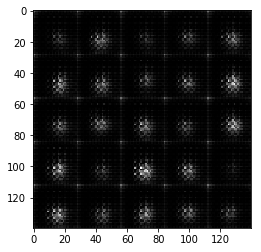

Epoch 1/2... Discriminator Loss: 0.3589... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 0.3139... Generator Loss: 2.4701
Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 0.1710... Generator Loss: 2.4566
Epoch 1/2... Discriminator Loss: 0.2893... Generator Loss: 2.1299
Epoch 1/2... Discriminator Loss: 1.5702... Generator Loss: 6.4805
Epoch 1/2... Discriminator Loss: 0.2951... Generator Loss: 3.3367
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 2.3747
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 3.0396
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 1.6948


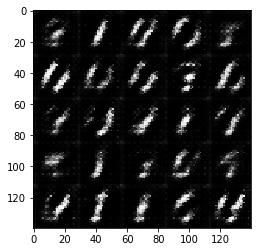

Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 2.3435
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.5769
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 1.7858... Generator Loss: 0.2612
Epoch 1/2... Discriminator Loss: 0.6499... Generator Loss: 2.0350
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 3.0028
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.6415


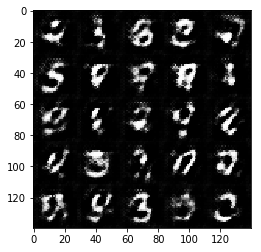

Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.5147
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.6787
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.3040
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 1.6748
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.8079
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.2982


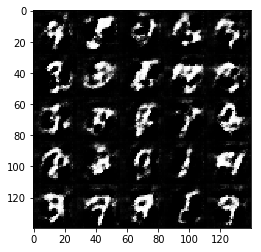

Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.7416
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.6488
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.8442


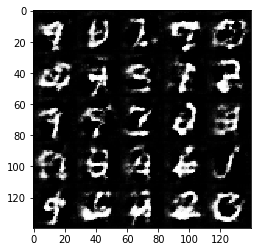

Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.7059
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 2.4968
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.8739
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 2.7613
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 0.7208


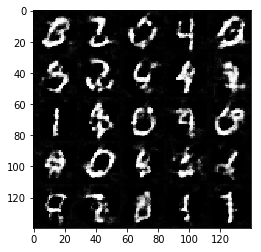

Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.3835
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.6439
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.0474
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.5854
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 2.1643


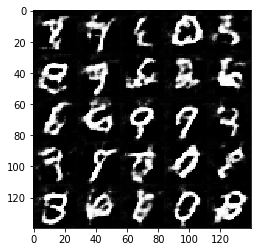

Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.8429
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 2.0476
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 2.7633
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.6401


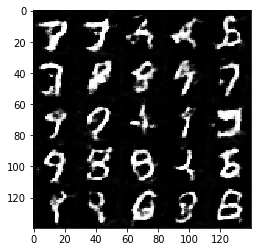

Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 0.5876
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.8896
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.5355
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 2.3320
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 2.6045
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 0.9729
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.7731


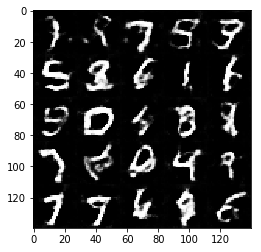

Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.2480
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 1.9613


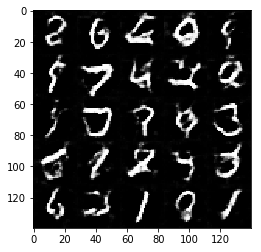

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 1.7169
Epoch 1/1... Discriminator Loss: 0.2126... Generator Loss: 2.8147
Epoch 1/1... Discriminator Loss: 0.2931... Generator Loss: 2.1126
Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 4.2063
Epoch 1/1... Discriminator Loss: 2.4337... Generator Loss: 0.1080
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 9.8074
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 3.9738
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 11.3055
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 1.9854


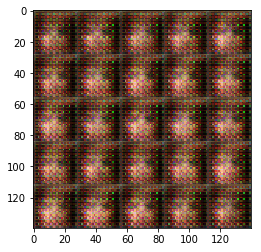

Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.3490
Epoch 1/1... Discriminator Loss: 0.2392... Generator Loss: 2.3007
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.6037
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 2.6784
Epoch 1/1... Discriminator Loss: 0.1971... Generator Loss: 2.7052
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.8175
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 2.6091
Epoch 1/1... Discriminator Loss: 0.1922... Generator Loss: 2.6145
Epoch 1/1... Discriminator Loss: 2.1484... Generator Loss: 8.3010


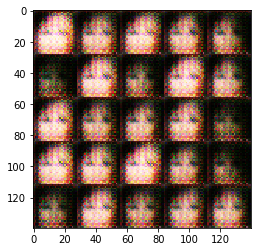

Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 3.3341
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 5.6329
Epoch 1/1... Discriminator Loss: 0.2851... Generator Loss: 2.1143
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 5.7258
Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 2.3281
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 8.5696
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 2.2525


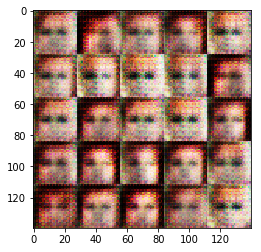

Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.8881
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.7664
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.0504


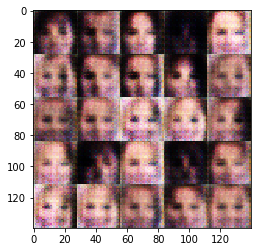

Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 2.4904
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 2.2623
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.1031


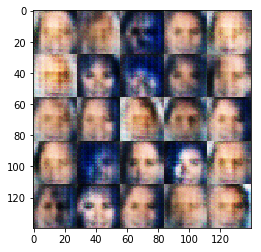

Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.2868


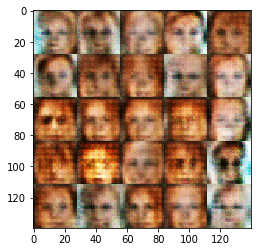

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 2.4959
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.1575


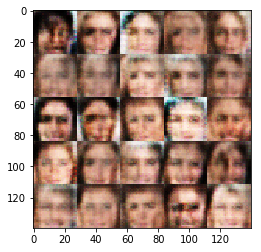

Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.2667

Images from final model:


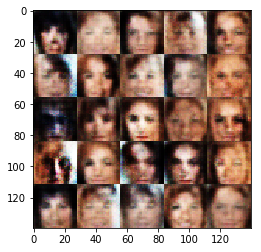

In [23]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.